## Personalized Learning (Localized Learning?)

#### This notebook includes the following online models;
1. A single global model with all data
2. Multiple local models (starting from a single global model)
   1. that are updated with new data
   2. that exchanges data in clusters
   3. that exchanges parameters in clusters

  
#### The dataset that is used for this project is [CIFAR-100 dataset][1]
* Has 100 classes containing 600 images each

#### New data are fed by the following rules;
1. Distributed, according to superclasses
  * Clusters will only be updated with data that belongs to a specific superclass
  * We update the NN by
    1. Changing all parameters of the NN
    2. Only changing the last few layers, as in many MTL models
2. Randomly (why?)

#### We expect to find an answer to the following research questions with this project;
1. If models are updated with data (or parameters) that are shared within a cluster, can the model perform good enough with the labels that count?
  * For example, the performance of the cluster that are updated with "Vehicles" superclass is only assessed with the labels that corresponds to the superclass.
  
[1]: https://www.cs.toronto.edu/~kriz/cifar.html

#### Questions

Retraining: how does it work <br>
How do we compare these models?


### Implementation with Custom Neural Network and EMNIST dataset

In [48]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [49]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [50]:
import matplotlib

In [51]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [52]:
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [53]:
tf.__version__

'1.15.2'

In [54]:
# Hyperparameters
batch_size = 50
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

#### Load MNIST dataset

In [55]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [56]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [57]:
x_train.shape

(60000, 28, 28, 1)

In [58]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [59]:
global_dataset_size = 6000
local_dataset_size = 40000

In [60]:
import utils

In [61]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/seth/projects/fed-learn-experiment/utils.py'>

In [62]:
len(x_train)

60000

In [15]:
x_train_0_to_4, y_train_0_to_4 = utils.filter_data_by_labels(x_train, y_train, np.arange(5))

In [16]:
x_train_5_to_9, y_train_5_to_9 = utils.filter_data_by_labels(x_train, y_train, np.arange(5)+5)

In [17]:
x_test_0_to_4, y_test_0_to_4 = utils.filter_data_by_labels(x_test, y_test, np.arange(5))

In [18]:
x_test_5_to_9, y_test_5_to_9 = utils.filter_data_by_labels(x_test, y_test, np.arange(5)+5)

In [19]:
# convert class vectors to binary class matrices
num_classes = 10
y_train_0_to_4 = keras.utils.to_categorical(y_train_0_to_4, num_classes)
y_train_5_to_9 = keras.utils.to_categorical(y_train_5_to_9, num_classes)
y_test_0_to_4 = keras.utils.to_categorical(y_test_0_to_4, num_classes)
y_test_5_to_9 = keras.utils.to_categorical(y_test_5_to_9, num_classes)

In [20]:
y_test = keras.utils.to_categorical(y_test, num_classes)

### Define models and compile & fit function

In [21]:
def custom_model():
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [22]:
def compile_model(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [23]:
def compile_model_lr(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [24]:
def fit_model_global(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(X_global, Y_global,
                      batch_size=100,
                      epochs=40,
                      shuffle=True, callbacks=[tensorboard_callback])

In [25]:
def fit_model_with_datasets(model, epochs, x_train, y_train):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True, validation_split=0.1, verbose=1)

In [26]:
init_model = custom_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [27]:
model1 = custom_model()
model2 = custom_model()
model1.set_weights(init_model.get_weights())
model2.set_weights(init_model.get_weights())
compile_model(model1)
compile_model(model2)

In [28]:
model1_list = list()
for _ in range(9):
    model1_list.append(tf.keras.models.clone_model(model1)) 
    model1_list[_].set_weights(model1.get_weights())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [29]:
for i in range(len(model1_list)):
    compile_model(model1_list[i])
    fit_model_with_datasets(model1_list[i], (i+1)*5, x_train_0_to_4, y_train_0_to_4)

Training date and time : 
2020-08-31 14:02:02
Train on 27536 samples, validate on 3060 samples
Epoch 1/5
27536/27536 [==============================] - 1s 45us/sample - loss: 0.0380 - acc: 0.7869 - val_loss: 0.0101 - val_acc: 0.9533
Epoch 2/5
27536/27536 [==============================] - 1s 32us/sample - loss: 0.0095 - acc: 0.9495 - val_loss: 0.0062 - val_acc: 0.9670
Epoch 3/5
27536/27536 [==============================] - 1s 30us/sample - loss: 0.0072 - acc: 0.9576 - val_loss: 0.0051 - val_acc: 0.9709
Epoch 4/5
27536/27536 [==============================] - 1s 29us/sample - loss: 0.0063 - acc: 0.9629 - val_loss: 0.0045 - val_acc: 0.9735
Epoch 5/5
27536/27536 [==============================] - 1s 29us/sample - loss: 0.0057 - acc: 0.9653 - val_loss: 0.0042 - val_acc: 0.9748
Training date and time : 
2020-08-31 14:02:06
Train on 27536 samples, validate on 3060 samples
Epoch 1/10
27536/27536 [==============================] - 1s 32us/sample - loss: 0.0379 - acc: 0.7862 - val_loss: 0.0100

27536/27536 [==============================] - 1s 29us/sample - loss: 0.0048 - acc: 0.9704 - val_loss: 0.0037 - val_acc: 0.9761
Epoch 9/35
27536/27536 [==============================] - 1s 29us/sample - loss: 0.0046 - acc: 0.9722 - val_loss: 0.0035 - val_acc: 0.9761
Epoch 10/35
27536/27536 [==============================] - 1s 30us/sample - loss: 0.0044 - acc: 0.9731 - val_loss: 0.0033 - val_acc: 0.9791
Epoch 11/35
27536/27536 [==============================] - 1s 29us/sample - loss: 0.0042 - acc: 0.9743 - val_loss: 0.0032 - val_acc: 0.9778
Epoch 12/35
27536/27536 [==============================] - 1s 29us/sample - loss: 0.0041 - acc: 0.9752 - val_loss: 0.0031 - val_acc: 0.9797
Epoch 13/35
27536/27536 [==============================] - 1s 29us/sample - loss: 0.0040 - acc: 0.9756 - val_loss: 0.0031 - val_acc: 0.9794
Epoch 14/35
27536/27536 [==============================] - 1s 29us/sample - loss: 0.0038 - acc: 0.9766 - val_loss: 0.0030 - val_acc: 0.9797
Epoch 15/35
27536/27536 [========

Epoch 31/40
27536/27536 [==============================] - 1s 30us/sample - loss: 0.0025 - acc: 0.9859 - val_loss: 0.0022 - val_acc: 0.9856
Epoch 32/40
27536/27536 [==============================] - 1s 29us/sample - loss: 0.0025 - acc: 0.9858 - val_loss: 0.0021 - val_acc: 0.9863
Epoch 33/40
27536/27536 [==============================] - 1s 29us/sample - loss: 0.0024 - acc: 0.9863 - val_loss: 0.0021 - val_acc: 0.9869
Epoch 34/40
27536/27536 [==============================] - 1s 30us/sample - loss: 0.0024 - acc: 0.9865 - val_loss: 0.0021 - val_acc: 0.9869
Epoch 35/40
27536/27536 [==============================] - 1s 29us/sample - loss: 0.0023 - acc: 0.9874 - val_loss: 0.0020 - val_acc: 0.9876
Epoch 36/40
27536/27536 [==============================] - 1s 30us/sample - loss: 0.0023 - acc: 0.9874 - val_loss: 0.0021 - val_acc: 0.9879
Epoch 37/40
27536/27536 [==============================] - 1s 30us/sample - loss: 0.0022 - acc: 0.9879 - val_loss: 0.0020 - val_acc: 0.9879
Epoch 38/40
27536/27

In [30]:
fit_model_with_datasets(model2, 50, x_train_5_to_9, y_train_5_to_9)

Training date and time : 
2020-08-31 14:05:10
Train on 26463 samples, validate on 2941 samples
Epoch 1/50
26463/26463 [==============================] - 1s 35us/sample - loss: 0.0515 - acc: 0.6787 - val_loss: 0.0195 - val_acc: 0.9157
Epoch 2/50
26463/26463 [==============================] - 1s 30us/sample - loss: 0.0174 - acc: 0.9040 - val_loss: 0.0111 - val_acc: 0.9408
Epoch 3/50
26463/26463 [==============================] - 1s 29us/sample - loss: 0.0129 - acc: 0.9223 - val_loss: 0.0092 - val_acc: 0.9534
Epoch 4/50
26463/26463 [==============================] - 1s 30us/sample - loss: 0.0111 - acc: 0.9313 - val_loss: 0.0083 - val_acc: 0.9565
Epoch 5/50
26463/26463 [==============================] - 1s 30us/sample - loss: 0.0100 - acc: 0.9380 - val_loss: 0.0076 - val_acc: 0.9572
Epoch 6/50
26463/26463 [==============================] - 1s 30us/sample - loss: 0.0092 - acc: 0.9437 - val_loss: 0.0071 - val_acc: 0.9602
Epoch 7/50
26463/26463 [==============================] - 1s 30us/sampl

In [31]:
import semantic_drift
model_dists = [semantic_drift.l2_distance(init_model, m) for m in model1_list]

In [32]:
model_dists

[2.537542,
 2.8945951,
 3.1361504,
 3.333924,
 3.511049,
 3.6732874,
 3.8236768,
 3.963264,
 4.097101]

### Aggregate models (all of model1s and only the final model2(e=50))

In [33]:
agg_weights_list_per_pi = list()
theta_list = [0, 0.5, 1]
for m1 in model1_list:
    weights = [m1.get_weights(), model2.get_weights()]
    agg_weights_list = list()
    for theta in theta_list:
        agg_weights = list()
        for weights_list_tuple in zip(*weights):
            agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
        agg_weights_list.append(agg_weights)
    agg_weights_list_per_pi.append(agg_weights_list)

In [34]:
model2.evaluate(x=x_test, y=y_test, verbose=1)

10000/10000 [==============================] - 0s 25us/sample - loss: 0.0906 - acc: 0.4733


[0.09059313377141953, 0.4733]

In [35]:
B = np.zeros(len(agg_weights_list_per_pi))
A = np.zeros(len(agg_weights_list_per_pi))

losses1 = list()
accs1 = list()
losses2 = list()
accs2 = list()
agg_accs = list()
acc_losses = list()

i = 0
for agg_weights_list in agg_weights_list_per_pi:

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[1])
    compile_model(aggr_model)
    score = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[0])
    compile_model(aggr_model)
    comp_score1 = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[2])
    compile_model(aggr_model)
    comp_score2 = aggr_model.evaluate(x=x_test, y=y_test, verbose=0)
    
    acc_losses.append(score[0])
    agg_accs.append(score[1])
    losses1.append(comp_score1[0])
    accs1.append(comp_score1[1])
    losses2.append(comp_score2[0])
    accs2.append(comp_score2[1])
    
    B[i] = min(comp_score1[0], comp_score2[0]) - score[0]
    A[i] = score[1] - max(comp_score1[1], comp_score2[1])
    K.clear_session() #prevent memory leak https://github.com/keras-team/keras/issues/13118
    i += 1
    if i % 10 == 0:
        print("{}th iteration".format(i))

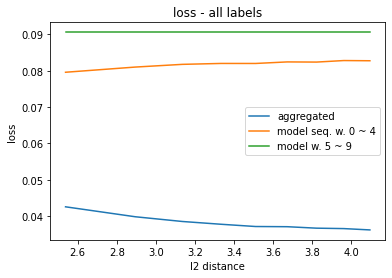

In [36]:
import matplotlib as plot
plt.plot(np.array(model_dists), np.array(acc_losses))
plt.plot(np.array(model_dists), np.array(losses1))
plt.plot(np.array(model_dists), np.array(losses2))
plt.legend(["aggregated", "model seq. w. 0 ~ 4", "model w. 5 ~ 9"])
plt.title("loss - all labels")
plt.ylabel("loss")
plt.xlabel("l2 distance")
plt.show()

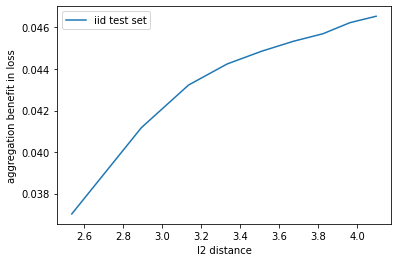

In [38]:
import matplotlib as plot
plt.plot(np.array(model_dists), np.array(B))
plt.legend(["iid test set", "test w. 0 ~ 4", "test w. 5 ~ 9"])
plt.ylabel("aggregation benefit in loss")
plt.xlabel("l2 distance")
plt.show()

In [46]:
B = np.zeros(len(agg_weights_list_per_pi))
A = np.zeros(len(agg_weights_list_per_pi))

losses1 = list()
losses2 = list()
agg_losses = list()

i = 0
for agg_weights_list in agg_weights_list_per_pi:

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[1])
    compile_model(aggr_model)
    score = aggr_model.evaluate(x=x_test_0_to_4, y=y_test_0_to_4, verbose=0)

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[0])
    compile_model(aggr_model)
    comp_score1 = aggr_model.evaluate(x=x_test_0_to_4, y=y_test_0_to_4, verbose=0)

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[2])
    compile_model(aggr_model)
    comp_score2 = aggr_model.evaluate(x=x_test_0_to_4, y=y_test_0_to_4, verbose=0)
    
    agg_losses.append(score[0])
    losses1.append(comp_score1[0])
    losses2.append(comp_score2[0])
    
    B[i] = min(comp_score1[0], comp_score2[0]) - score[0]
    A[i] = score[1] - max(comp_score1[1], comp_score2[1])
    K.clear_session() #prevent memory leak https://github.com/keras-team/keras/issues/13118
    i += 1
    if i % 10 == 0:
        print("{}th iteration".format(i))

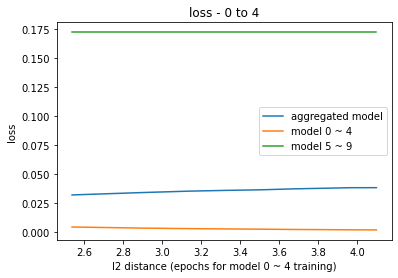

In [47]:
import matplotlib as plot
plt.plot(np.array(model_dists), np.array(acc_losses))
plt.plot(np.array(model_dists), np.array(losses1))
plt.plot(np.array(model_dists), np.array(losses2))
plt.legend(["aggregated model", "model 0 ~ 4", "model 5 ~ 9"])
plt.title("loss - 0 to 4")
plt.ylabel("loss")
plt.xlabel("l2 distance (epochs for model 0 ~ 4 training)")
plt.show()

In [43]:
B = np.zeros(len(agg_weights_list_per_pi))
A = np.zeros(len(agg_weights_list_per_pi))

losses1 = list()
accs1 = list()
losses2 = list()
accs2 = list()
agg_accs = list()
acc_losses = list()

i = 0
for agg_weights_list in agg_weights_list_per_pi:

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[1])
    compile_model(aggr_model)
    score = aggr_model.evaluate(x=x_test_5_to_9, y=y_test_5_to_9, verbose=0)

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[0])
    compile_model(aggr_model)
    comp_score1 = aggr_model.evaluate(x=x_test_5_to_9, y=y_test_5_to_9, verbose=0)

    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights_list[2])
    compile_model(aggr_model)
    comp_score2 = aggr_model.evaluate(x=x_test_5_to_9, y=y_test_5_to_9, verbose=0)
    
    acc_losses.append(score[0])
    agg_accs.append(score[1])
    losses1.append(comp_score1[0])
    accs1.append(comp_score1[1])
    losses2.append(comp_score2[0])
    accs2.append(comp_score2[1])
    
    B[i] = min(comp_score1[0], comp_score2[0]) - score[0]
    A[i] = score[1] - max(comp_score1[1], comp_score2[1])
    K.clear_session() #prevent memory leak https://github.com/keras-team/keras/issues/13118
    i += 1
    if i % 10 == 0:
        print("{}th iteration".format(i))

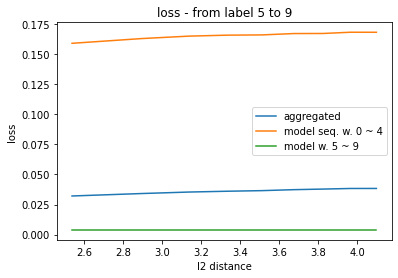

In [44]:
plt.plot(np.array(model_dists), np.array(acc_losses))
plt.plot(np.array(model_dists), np.array(losses1))
plt.plot(np.array(model_dists), np.array(losses2))
plt.legend(["aggregated", "model seq. w. 0 ~ 4", "model w. 5 ~ 9"])
plt.title("loss - from label 5 to 9")
plt.ylabel("loss")
plt.xlabel("l2 distance")
plt.show()

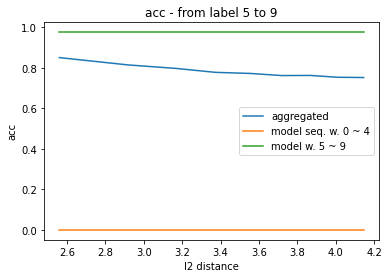

In [70]:
plt.plot(np.array(model_dists), np.array(agg_accs))
plt.plot(np.array(model_dists), np.array(accs1))
plt.plot(np.array(model_dists), np.array(accs2))
plt.legend(["aggregated", "model seq. w. 0 ~ 4", "model w. 5 ~ 9"])
plt.title("acc - from label 5 to 9")
plt.ylabel("acc")
plt.xlabel("l2 distance")
plt.show()